In [32]:
#Import potrebnih biblioteka i ekstenzija
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.cluster as cluster

In [33]:
data = pd.read_csv('spotify.csv')
#Pravimo novi dataset koji sadrži samo pesme čiji speechiness je manji od ili jednak 60
cl_data = data[data["speechiness"] <= 60].copy()
#Prikaz podataka
cl_data

,track_name,released_year,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,in_apple_charts,bpm,mode,energy,instrumentalness,liveness,speechiness
0,Seven (feat. Latto) (Explicit Ver.),2023,553,147,141381703,43,263.0,125,Major,83,0,8,4
1,LALA,2023,1474,48,133716286,48,126.0,92,Major,74,0,10,4
2,vampire,2023,1397,113,140003974,94,207.0,138,Major,53,0,31,6
3,Cruel Summer,2019,7858,-,800840817,116,207.0,170,Major,72,0,11,15
4,WHERE SHE GOES,2023,3133,50,303236322,84,133.0,144,Minor,80,63,11,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
948,My Mind & Me,2022,953,0,91473363,61,13.0,144,Major,39,0,8,3
949,Bigger Than The Whole Sky,2022,1180,0,121871870,4,0.0,166,Major,24,1,12,6
950,A Veces (feat. Feid),2022,573,0,73513683,2,0.0,92,Major,67,0,8,6
951,En La De Ella,2022,1320,0,133895612,29,26.0,97,Major,77,0,12,5


In [34]:
#Provera tipa promenljivih
cl_data.info()
# Promenljiva in_spotify_charts je tipa object (zapravo se tretira kao String)

<class 'pandas.core.frame.DataFrame'>
Index: 952 entries, 0 to 952
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   track_name            952 non-null    object 
 1   released_year         952 non-null    int64  
 2   in_spotify_playlists  952 non-null    int64  
 3   in_spotify_charts     951 non-null    object 
 4   streams               952 non-null    int64  
 5   in_apple_playlists    952 non-null    int64  
 6   in_apple_charts       950 non-null    float64
 7   bpm                   952 non-null    int64  
 8   mode                  952 non-null    object 
 9   energy                952 non-null    int64  
 10  instrumentalness      952 non-null    int64  
 11  liveness              952 non-null    int64  
 12  speechiness           952 non-null    int64  
dtypes: float64(1), int64(9), object(3)
memory usage: 104.1+ KB


In [35]:
# Gledamo deskriptivne statistike za numeričke promenljive
cl_data.describe()
# Izdvaja se to da instrumentalness uglavnom sadrži nule (sve do 75 kvartila), pa je pitanje
# da li zapravo ima smisla koristiti tu promenljivu
#Osim toga, released_year uglavnom čine pesme iz raspona 2020-2023 (25 kvartil do max) i pitanje
# je da li to kao informacija doprinosi boljoj klasterizaciji

,released_year,in_spotify_playlists,streams,in_apple_playlists,in_apple_charts,bpm,energy,instrumentalness,liveness,speechiness
count,952.000000,952.000000,9.520000e+02,952.000000,950.000000,952.000000,952.000000,952.000000,952.000000,952.000000
mean,2018.233193,5205.304622,5.146578e+08,67.876050,51.746316,122.555672,64.297269,1.582983,18.211134,10.074580
std,11.120988,7900.140377,5.666776e+08,86.464421,50.426462,28.068585,16.549733,8.414064,13.718308,9.762894
min,1930.000000,31.000000,2.762000e+03,0.000000,0.000000,65.000000,9.000000,0.000000,3.000000,2.000000
25%,2020.000000,878.750000,1.420017e+08,13.000000,7.000000,99.750000,53.000000,0.000000,10.000000,4.000000
50%,2022.000000,2225.000000,2.912715e+08,34.000000,38.000000,121.000000,66.000000,0.000000,12.000000,6.000000
75%,2022.000000,5573.750000,6.738690e+08,88.000000,86.000000,140.250000,77.000000,0.000000,24.000000,11.000000
max,2023.000000,52898.000000,3.703895e+09,672.000000,275.000000,206.000000,97.000000,91.000000,97.000000,59.000000


In [36]:
# Razmatramo sledeće promenljive za izbacivanje:
# track_name - nije nam bitan naziv pesme radi klasterizacije, a i nije numerička promenljiva
# mode - nije numerička, već kategorijska promenljiva. Pošto ima samo dve vrednosti (Major i Minor)
# transformisaćemo je u binarnu (numeričku) varijablu mapiranjem u sledećem koraku (npr. 0 - Major,
# 1 - Minor) i upotrebićemo je u klasterizaciji - nećemo je izbaciti.
# Za promenljivu instrumentalness, uglavnom važi da je čine nule (o do 75 kvartila), pa nju izbacujemo
# Ostale promenljive su numeričke (osim in_spotify_charts koja je tipa object, a trebalo
# bi da bude broj ali to ćemo naknadno videti zašto u sledećem koraku) tako da one ostaju - za sada.
cl_data.drop(columns = ["track_name", "instrumentalness"], inplace = True)

In [37]:
# Pretvaramo kolonu in_spotify_charts u numeričku i menjamo pogrešno unete vrednosti ('-', "" ili '_' ili tj. sve što nije broj) sa NA vrednostima
cl_data["in_spotify_charts"] = pd.to_numeric(cl_data["in_spotify_charts"], errors='coerce')
# Ponovo pogledamo tipove promenljivih
cl_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 952 entries, 0 to 952
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   released_year         952 non-null    int64  
 1   in_spotify_playlists  952 non-null    int64  
 2   in_spotify_charts     950 non-null    float64
 3   streams               952 non-null    int64  
 4   in_apple_playlists    952 non-null    int64  
 5   in_apple_charts       950 non-null    float64
 6   bpm                   952 non-null    int64  
 7   mode                  952 non-null    object 
 8   energy                952 non-null    int64  
 9   liveness              952 non-null    int64  
 10  speechiness           952 non-null    int64  
dtypes: float64(2), int64(8), object(1)
memory usage: 89.2+ KB


In [38]:
# Kolona mode jedina nije numerička, ali nju ćemo sada pretvoriti u
# binarnu (numeričku) varijablu mapiranjem u sledećem koraku (npr. 0 - Major,
# 1 - Minor)
cl_data["mode"] = cl_data["mode"].map({'Major': 0, 'Minor': 1})
# Ponovo pogledamo tipove promenljivih
cl_data.info()
# Pogledamo i raspodelu promenljive mode
cl_data["mode"].describe()

<class 'pandas.core.frame.DataFrame'>
Index: 952 entries, 0 to 952
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   released_year         952 non-null    int64  
 1   in_spotify_playlists  952 non-null    int64  
 2   in_spotify_charts     950 non-null    float64
 3   streams               952 non-null    int64  
 4   in_apple_playlists    952 non-null    int64  
 5   in_apple_charts       950 non-null    float64
 6   bpm                   952 non-null    int64  
 7   mode                  952 non-null    int64  
 8   energy                952 non-null    int64  
 9   liveness              952 non-null    int64  
 10  speechiness           952 non-null    int64  
dtypes: float64(2), int64(9)
memory usage: 89.2 KB


count    952.000000
mean       0.422269
std        0.494181
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: mode, dtype: float64

In [39]:
#Proveravamo nedostajuće vrednosti po kolonama (koje su sada sve brojevi)
print(cl_data.isnull().sum())
#Proverimo i deskriptivne statistike (nedostajuće vrednosti se i ovde vide u redu count za kolone
# in_spotify_charts i in_apple_charts gde nije 952 već po 950)
cl_data.describe()

released_year           0
in_spotify_playlists    0
in_spotify_charts       2
streams                 0
in_apple_playlists      0
in_apple_charts         2
bpm                     0
mode                    0
energy                  0
liveness                0
speechiness             0
dtype: int64


,released_year,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,in_apple_charts,bpm,mode,energy,liveness,speechiness
count,952.000000,952.000000,950.000000,9.520000e+02,952.000000,950.000000,952.000000,952.000000,952.000000,952.000000,952.000000
mean,2018.233193,5205.304622,11.880000,5.146578e+08,67.876050,51.746316,122.555672,0.422269,64.297269,18.211134,10.074580
std,11.120988,7900.140377,19.345299,5.666776e+08,86.464421,50.426462,28.068585,0.494181,16.549733,13.718308,9.762894
min,1930.000000,31.000000,0.000000,2.762000e+03,0.000000,0.000000,65.000000,0.000000,9.000000,3.000000,2.000000
25%,2020.000000,878.750000,0.000000,1.420017e+08,13.000000,7.000000,99.750000,0.000000,53.000000,10.000000,4.000000
50%,2022.000000,2225.000000,3.000000,2.912715e+08,34.000000,38.000000,121.000000,0.000000,66.000000,12.000000,6.000000
75%,2022.000000,5573.750000,16.000000,6.738690e+08,88.000000,86.000000,140.250000,1.000000,77.000000,24.000000,11.000000
max,2023.000000,52898.000000,147.000000,3.703895e+09,672.000000,275.000000,206.000000,1.000000,97.000000,97.000000,59.000000


In [40]:

# Isto tako, ok je i da zamenimo te četiri nedostajuće vrednosti srednjom vrednošću (medijana) za tu kolonu.
cl_data.loc[cl_data["in_spotify_charts"].isnull(), "in_spotify_charts"] = cl_data["in_spotify_charts"].median()
cl_data.loc[cl_data["in_apple_charts"].isnull(), "in_apple_charts"] = cl_data["in_apple_charts"].median()
print(cl_data.isnull().sum())
# Ostaje svih 952 instanci i nigde ne postoji nijedna nedostajuća vrednost
cl_data.info()

released_year           0
in_spotify_playlists    0
in_spotify_charts       0
streams                 0
in_apple_playlists      0
in_apple_charts         0
bpm                     0
mode                    0
energy                  0
liveness                0
speechiness             0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 952 entries, 0 to 952
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   released_year         952 non-null    int64  
 1   in_spotify_playlists  952 non-null    int64  
 2   in_spotify_charts     952 non-null    float64
 3   streams               952 non-null    int64  
 4   in_apple_playlists    952 non-null    int64  
 5   in_apple_charts       952 non-null    float64
 6   bpm                   952 non-null    int64  
 7   mode                  952 non-null    int64  
 8   energy                952 non-null    int64  
 9   liveness              952 non-null 

In [41]:
# Ovde sada postoji jedan veliki problem sa kodiranjem podataka koji će da utiče na klasterizaciju
# a odnosi se na ove dve kolone: in_spotify_charts i in_apple_charts. Ako se pesma ne pojavljuje
# na top listi, stoji vrednost 0. Najbolje pesme su na 1, 2 i 3 mestu a najgore na 147 odnosno 275
# mestu (max) tj. što je niži broj, pesma je bolja.
# - Ako se ostave ove nule, dobija se iskrivljena slika da su to NAJBOLJE pesme (0 je manje od 1, 2, 3...)
# - Ako se zamene medijanom za tu kolonu, dobija se iskrivljena slika da su to osrednje pesme.
#
# Možda je najbolje da se ove vrednosti
# zamene sa max vrednošću za tu kolonu da bi se dobila realna slika o poziciji tih pesama na top listama.
cl_data.loc[cl_data["in_apple_charts"]==0, "in_apple_charts"] = cl_data["in_apple_charts"].max()
cl_data.loc[cl_data["in_spotify_charts"]==0, "in_spotify_charts"] = cl_data["in_spotify_charts"].max()
# Sve nule iz ove dve kolone su zamenjene max vrednostima
cl_data.describe()

,released_year,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,in_apple_charts,bpm,mode,energy,liveness,speechiness
count,952.000000,952.000000,952.000000,9.520000e+02,952.000000,952.000000,952.000000,952.000000,952.000000,952.000000,952.000000
mean,2018.233193,5205.304622,74.398109,5.146578e+08,67.876050,80.603992,122.555672,0.422269,64.297269,18.211134,10.074580
std,11.120988,7900.140377,64.622987,5.666776e+08,86.464421,81.631508,28.068585,0.494181,16.549733,13.718308,9.762894
min,1930.000000,31.000000,1.000000,2.762000e+03,0.000000,1.000000,65.000000,0.000000,9.000000,3.000000,2.000000
25%,2020.000000,878.750000,11.000000,1.420017e+08,13.000000,16.000000,99.750000,0.000000,53.000000,10.000000,4.000000
50%,2022.000000,2225.000000,42.000000,2.912715e+08,34.000000,58.500000,121.000000,0.000000,66.000000,12.000000,6.000000
75%,2022.000000,5573.750000,147.000000,6.738690e+08,88.000000,108.250000,140.250000,1.000000,77.000000,24.000000,11.000000
max,2023.000000,52898.000000,147.000000,3.703895e+09,672.000000,275.000000,206.000000,1.000000,97.000000,97.000000,59.000000


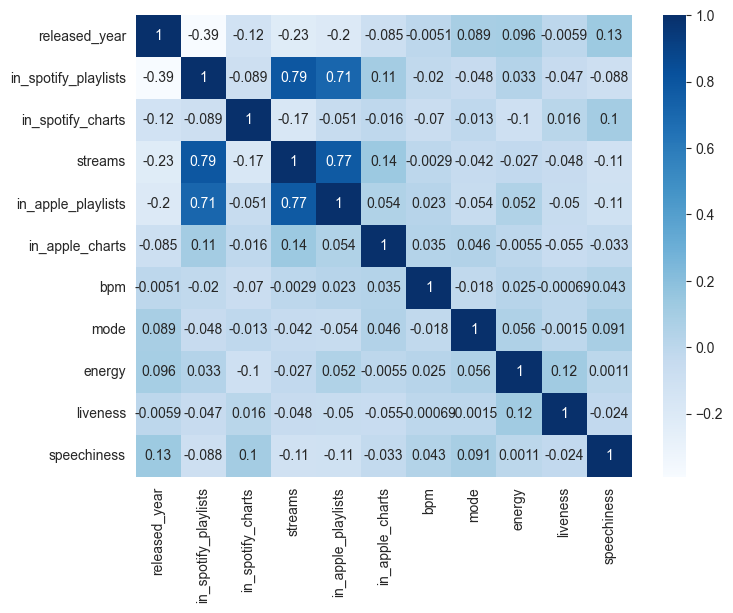

In [42]:
#Korelacije
import seaborn as sb
# Proveravamo korelacije preostalih promenljivih
plt.figure(figsize=(8,6))
sb.heatmap(cl_data.corr(), cmap="Blues",annot=True)
plt.show()

In [43]:
#Promenljive streams, in_apple_playlists i in_spotify_playlists su međusobno visoko korelisane (svaka sa svakom)
#i to će puno da utiče na rezultate klasterizacije. Izbacićemo bilo koje dve od te tri, na primer streams i
# in_apple_playlists
cl_data.drop(columns = ["in_apple_playlists", "streams"], inplace = True)

In [44]:
# Proveravamo šta je ostalo od podataka
cl_data

,released_year,in_spotify_playlists,in_spotify_charts,in_apple_charts,bpm,mode,energy,liveness,speechiness
0,2023,553,147.0,263.0,125,0,83,8,4
1,2023,1474,48.0,126.0,92,0,74,10,4
2,2023,1397,113.0,207.0,138,0,53,31,6
3,2019,7858,3.0,207.0,170,0,72,11,15
4,2023,3133,50.0,133.0,144,1,80,11,6
...,...,...,...,...,...,...,...,...,...
948,2022,953,147.0,13.0,144,0,39,8,3
949,2022,1180,147.0,275.0,166,0,24,12,6
950,2022,573,147.0,275.0,92,0,67,8,6
951,2022,1320,147.0,26.0,97,0,77,12,5


In [45]:
# Uvodimo pomoćnu funkciju draw_boxplot koja crta i prikazuje boxplot
def draw_boxplot(podaci, naslov):
    plt.boxplot(podaci)
    plt.xlabel(naslov)
    plt.show()

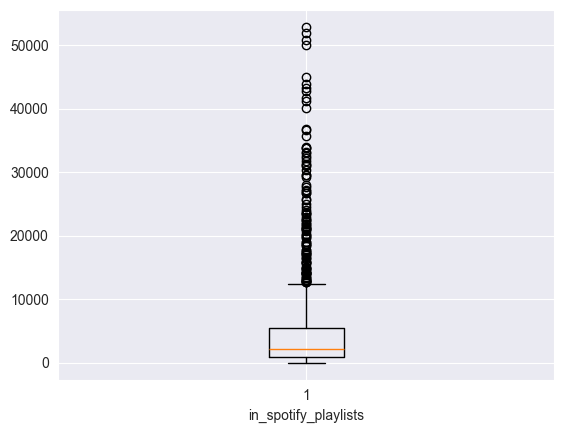

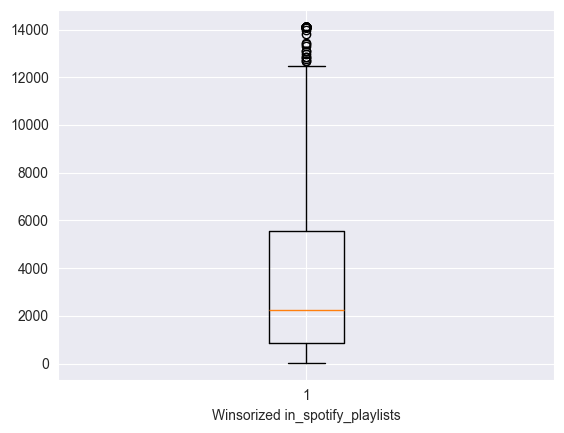

In [46]:
from scipy.stats.mstats import winsorize
#Tražimo outliere, kolona "in_spotify_playlists"
draw_boxplot(cl_data["in_spotify_playlists"], "in_spotify_playlists")
# ima outliere samo na gornjoj granici, winsorize u rasponu 0 - 90 ne otklanja sve outlier-e
winsorized_data = winsorize(cl_data["in_spotify_playlists"], limits=[0.00, 0.10])
draw_boxplot(winsorized_data, "Winsorized in_spotify_playlists")
plt.show()
#Zaključak je da više od 10% vrednosti ove promenljive čine outlier-i i treba je izbaciti iz dataset-a
cl_data.drop(columns = ["in_spotify_playlists"], inplace = True)

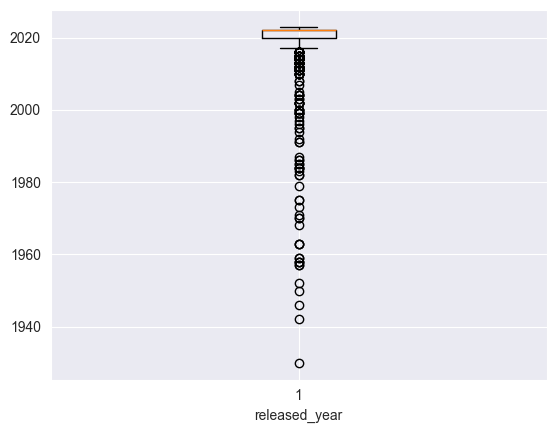

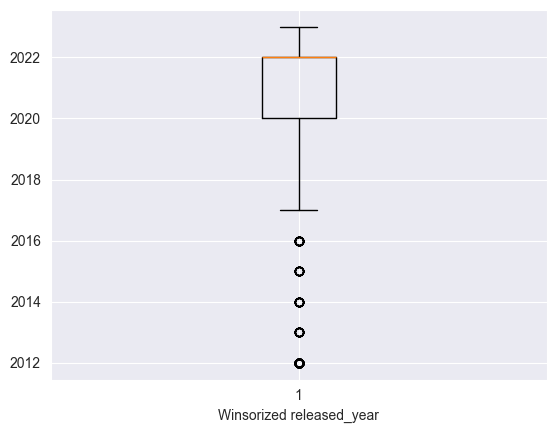

In [47]:
#Tražimo outliere, kolona "released_year"
draw_boxplot(cl_data["released_year"], "released_year")
# ima outliere samo na donjoj granici, winsorize u rasponu 10 - 100 ne otklanja sve outlier-e
winsorized_data = winsorize(cl_data["released_year"], limits=[0.10, 0.00])
draw_boxplot(winsorized_data, "Winsorized released_year")
#Zaključak je da više od 10% vrednosti ove promenljive čine outlier-i i treba je izbaciti iz dataset-a
cl_data.drop(columns = ["released_year"], inplace = True)

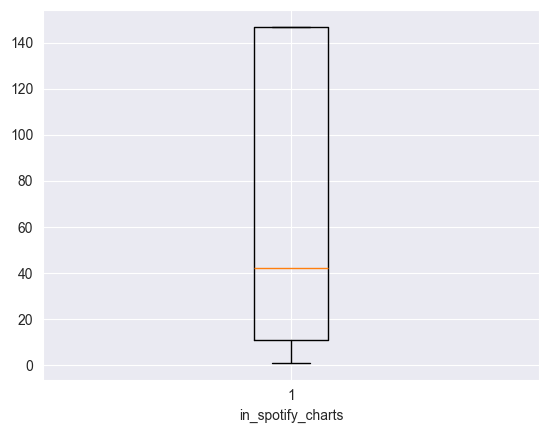

In [48]:
#Tražimo outliere, kolona "in_spotify_charts"
draw_boxplot(cl_data["in_spotify_charts"], "in_spotify_charts")
# Zaključak je da nema outlier-e i da ništa ne treba menjati u ovoj koloni

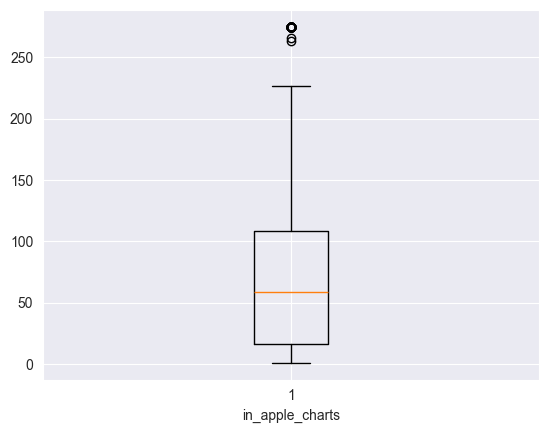

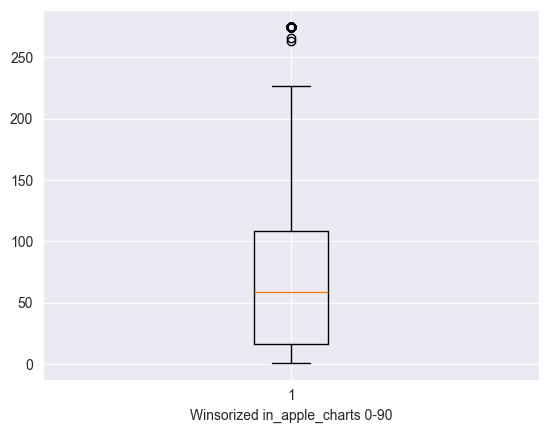

In [49]:
#Tražimo outliere, kolona "in_apple_charts"
draw_boxplot(cl_data["in_apple_charts"], "in_apple_charts")
# ima outliere samo na gornjoj granici, winsorize u rasponu 0 - 90 NE otklanja sve outlier-e
winsorized_data = winsorize(cl_data["in_apple_charts"], limits=[0.00, 0.10])
draw_boxplot(winsorized_data, "Winsorized in_apple_charts 0-90")
#Zaključak je da više od 10% vrednosti ove primenljive čine outlier-i i treba je izbaciti iz dataset-a
cl_data.drop(columns = ["in_apple_charts"], inplace = True)

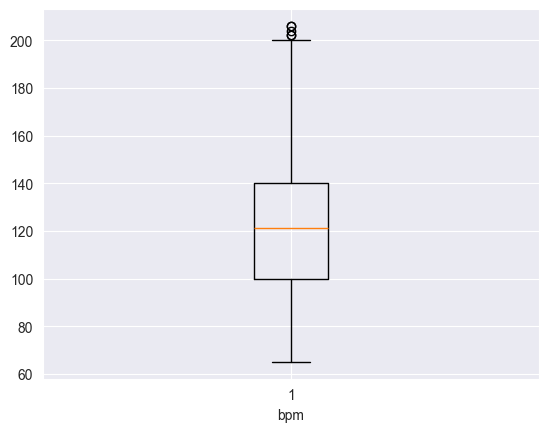

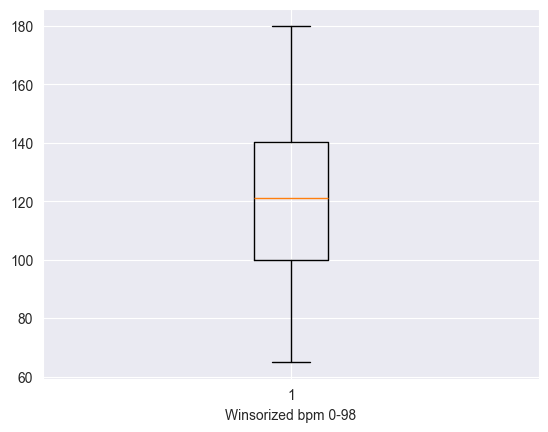

In [50]:
#Tražimo outliere, kolona "bpm"
draw_boxplot(cl_data["bpm"], "bpm")
# ima outliere samo na gornjoj granici, winsorize u rasponu 0 - 98 otklanja sve outlier-e
winsorized_data = winsorize(cl_data["bpm"], limits=[0.00, 0.02])
draw_boxplot(winsorized_data, "Winsorized bpm 0-98")
#Zaključak je da manje od 2% vrednosti ove primenljive čine outlier-i i treba te vrednosti zameniti winsorize vrednostima
cl_data["bpm"] = winsorized_data

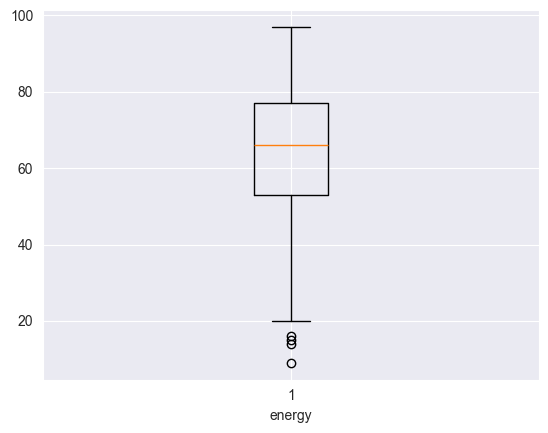

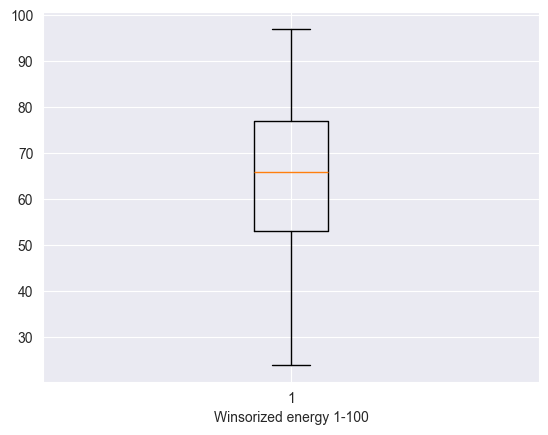

In [51]:
#Tražimo outliere, kolona "energy"
draw_boxplot(cl_data["energy"], "energy")
# ima outliere samo na donjoj granici, winsorize u rasponu 1 - 100 otklanja sve outlier-e
winsorized_data = winsorize(cl_data["energy"], limits=[0.01, 0.00])
draw_boxplot(winsorized_data, "Winsorized energy 1-100")
#Zaključak je da manje od 1% vrednosti ove primenljive čine outlier-i i treba te vrednosti zameniti winsorize vrednostima
cl_data["energy"] = winsorized_data

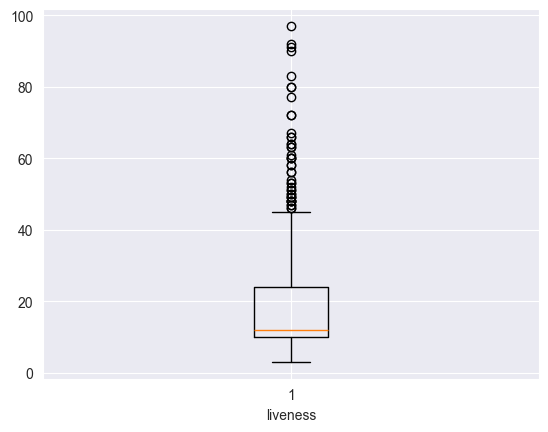

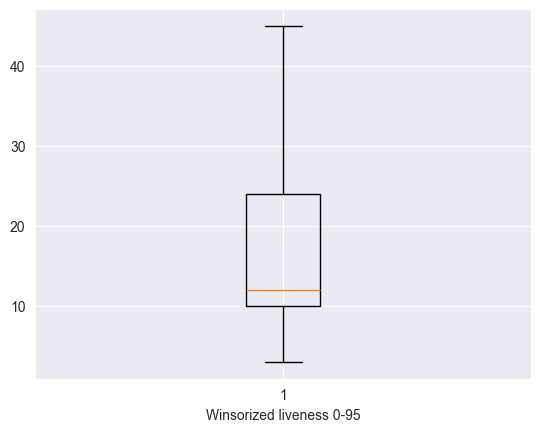

In [52]:
#Tražimo outliere, kolona "liveness"
draw_boxplot(cl_data["liveness"], "liveness")
# ima outliere samo na gornjoj granici, winsorize u rasponu 0 - 95 otklanja sve outlier-e
winsorized_data = winsorize(cl_data["liveness"], limits=[0.00, 0.05])
draw_boxplot(winsorized_data, "Winsorized liveness 0-95")
#Zaključak je da manje od 5% vrednosti ove primenljive čine outlier-i i treba te vrednosti zameniti winsorize vrednostima
cl_data["liveness"] = winsorized_data

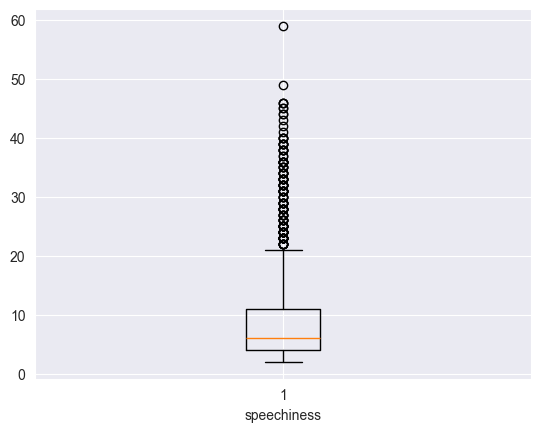

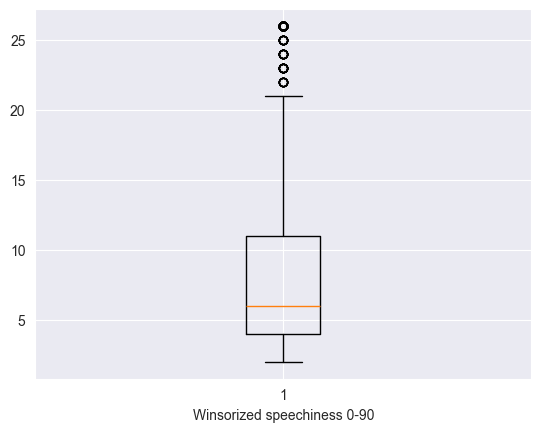

In [53]:
#Tražimo outliere, kolona "speechiness"
draw_boxplot(cl_data["speechiness"], "speechiness")
# ima outliere samo na gornjoj granici, winsorize u rasponu 0 - 90 NE otklanja sve outlier-e
winsorized_data = winsorize(cl_data["speechiness"], limits=[0.00, 0.10])
draw_boxplot(winsorized_data, "Winsorized speechiness 0-90")
#Zaključak je da više od 10% vrednosti ove primenljive čine outlier-i i treba je izbaciti iz dataset-a
cl_data.drop(columns = ["speechiness"], inplace = True)

In [54]:
# Posle izbacivanja NA vrednosti, sređivanja i izbacivanja promenljivih sa korelacijama i outlier-ima, ostaje ovo
cl_data.describe()
# Pet promenljivih dolazi u obzir za klasterizaciju

,in_spotify_charts,bpm,mode,energy,liveness
count,952.000000,952.000000,952.000000,952.000000,952.000000
mean,74.398109,122.316176,0.422269,64.359244,17.460084
std,64.622987,27.490861,0.494181,16.380695,11.231925
min,1.000000,65.000000,0.000000,24.000000,3.000000
25%,11.000000,99.750000,0.000000,53.000000,10.000000
50%,42.000000,121.000000,0.000000,66.000000,12.000000
75%,147.000000,140.250000,1.000000,77.000000,24.000000
max,147.000000,180.000000,1.000000,97.000000,45.000000


In [55]:
#Skaliranje/normalizacija
from sklearn.preprocessing import MinMaxScaler
# Promenljive su u veoma različitim rasponima, potrebna je normalizacija na skalu 0-1
# Koristimo MinMaxScaler koji vraća numpy array koji pretvaramo nazad u DataFrame
temp_data = MinMaxScaler().fit_transform(cl_data)
cl_data_scaled = pd.DataFrame(temp_data, columns = cl_data.columns)
# Proveravamo da li je sve skalirano kako treba (raspon od 0 do 1)
cl_data_scaled.describe()

,in_spotify_charts,bpm,mode,energy,liveness
count,952.000000,952.000000,952.000000,952.000000,952.000000
mean,0.502727,0.498402,0.422269,0.552866,0.344288
std,0.442623,0.239051,0.494181,0.224393,0.267427
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.068493,0.302174,0.000000,0.397260,0.166667
50%,0.280822,0.486957,0.000000,0.575342,0.214286
75%,1.000000,0.654348,1.000000,0.726027,0.500000
max,1.000000,1.000000,1.000000,1.000000,1.000000


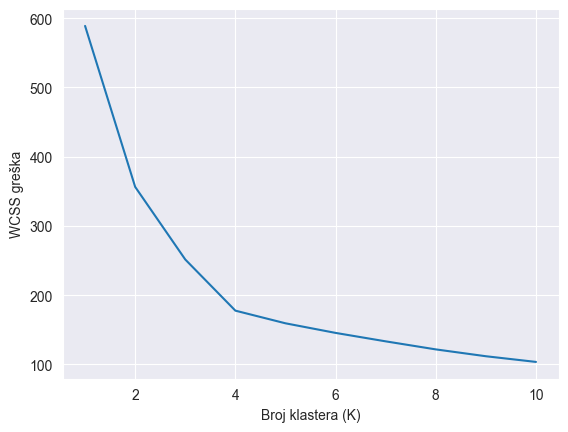

[588.8063314692282,
 356.359554172358,
 251.51174616186609,
 177.65990678004806,
 159.39237384561426,
 145.52468480083306,
 133.33486488019446,
 121.71755001650003,
 111.83126557085683,
 103.62406324522092]

In [56]:
#Primena Elbow metode kako bismo utvrdili najbolju vrednost za broj klastera (k)
wcss = []
# Probamo od 1 do 10 klastera
for i in range(1, 11):
    kmeans = cluster.KMeans(n_clusters=i, init='k-means++', max_iter=100, n_init=1000, random_state=0).fit(cl_data_scaled)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.xlabel("Broj klastera (K)")
plt.ylabel("WCSS greška")
plt.show()
wcss
# "Lakat" se pojavljuje kod 2. klastera i kod 4. klastera

In [57]:
# Radimo KMeans klasterizaciju sa dva klastera i kmeans++ metodom za inicijalizaciju težišta
kmeans = cluster.KMeans(n_clusters=2, init='k-means++', max_iter=100, n_init=1000, random_state=0)
kmeans.fit(cl_data_scaled)
# U dataset u kojem se nalaze skalirani podaci
# dodajemo novu kolonu sa oznakama koja instanca pripada kojem klasteru
cl_data_scaled["cluster"] = kmeans.labels_

In [58]:
#Prikaz
cl_data_scaled

,in_spotify_charts,bpm,mode,energy,liveness,cluster
0,1.000000,0.521739,0.0,0.808219,0.119048,1
1,0.321918,0.234783,0.0,0.684932,0.166667,1
2,0.767123,0.634783,0.0,0.397260,0.666667,1
3,0.013699,0.913043,0.0,0.657534,0.190476,1
4,0.335616,0.686957,1.0,0.767123,0.190476,0
...,...,...,...,...,...,...
947,1.000000,0.686957,0.0,0.205479,0.119048,1
948,1.000000,0.878261,0.0,0.000000,0.214286,1
949,1.000000,0.234783,0.0,0.589041,0.119048,1
950,1.000000,0.278261,0.0,0.726027,0.214286,1


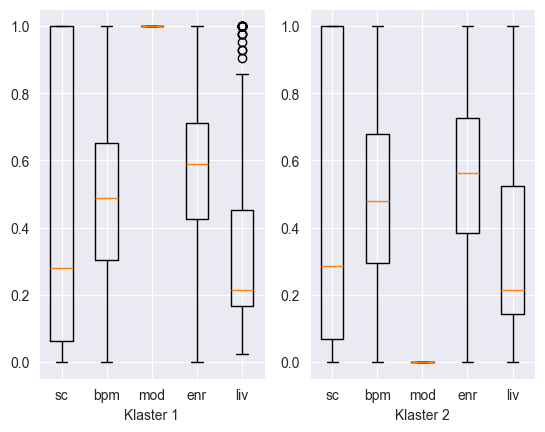

Klaster 1, N =  402
Klaster 2, N =  550


In [59]:
#Iscrtamo i uporedne boxplot-ove za ova dva klastera da bi ih uporedili u smislu sadržaja
fig, ax = plt.subplots(1,2)
ax[0].boxplot(cl_data_scaled[cl_data_scaled["cluster"]==0].drop(columns = "cluster"), tick_labels=("sc", "bpm", "mod", "enr", "liv"))
ax[0].set_xlabel("Klaster 1")
ax[1].boxplot(cl_data_scaled[cl_data_scaled["cluster"]==1].drop(columns = "cluster"), tick_labels=("sc", "bpm", "mod", "enr", "liv"))
ax[1].set_xlabel("Klaster 2")
plt.show()
print("Klaster 1, N = ", cl_data_scaled.loc[cl_data_scaled["cluster"]==0, "cluster"].count())
print("Klaster 2, N = ", cl_data_scaled.loc[cl_data_scaled["cluster"]==1, "cluster"].count())
# Tumačenje
# Veličina klastera
# 1. Prvi klaster ima 402 pesme a drugi 550 pesama, oba su slične veličine.
# 2. Centri klastera
# U klasteru 1 se isključivo nalaze pesme u Minor modu (1) a u klasteru 2 pesme u Major modu (0). Druga, doduše
# minimalna razlika je to da je energy nivo malo niži za pesme iz drugog klastera. Pitanje je da li je ovakva
# klasterizacija naročito smislena jer su po svim ostalim karakteristikama pesme skoro iste u oba klastera.
# 3. Disperzija od centara
# Za oba klastera možemo da kažemo da su skoro iste homogenosti, jedina razlika je u kolonama energy i liveness
# gde je klaster 1 malo homogeniji (manja disperzija). Međutim, disperzija je inače jako velika u oba
# klastera, što opet znači da  bi možda trebalo probati sa klasterizacijom sa četiri klastera.

In [60]:
# Radimo KMeans klasterizaciju sa četiri klastera i kmeans++ metodom za inicijalizaciju težišta
kmeans = cluster.KMeans(n_clusters=4, init='k-means++', max_iter=100, n_init=1000, random_state=0)
kmeans.fit(cl_data_scaled)
# U dataset u kojem se nalaze skalirani podaci
# dodajemo novu kolonu sa oznakama koja instanca
# pripada kojem klasteru
cl_data_scaled["cluster"] = kmeans.labels_

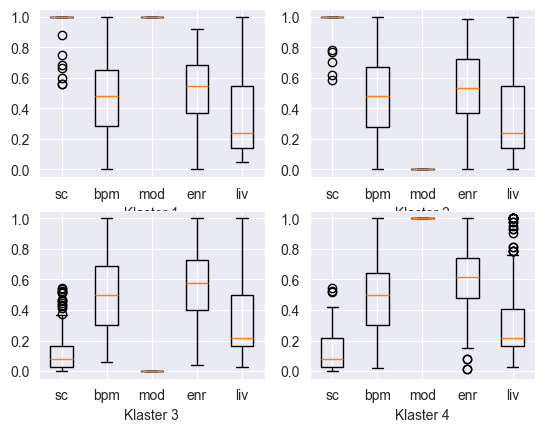

Klaster 1, N =  173
Klaster 2, N =  245
Klaster 3, N =  305
Klaster 4, N =  229


In [61]:
# Iscrtamo i uporedne boxplot-ove za ova četiri klastera da bi ih uporedili u smislu sadržaja
fig, ax = plt.subplots(2,2)
ax[0,0].boxplot(cl_data_scaled[cl_data_scaled["cluster"]==0].drop(columns = ['cluster']), tick_labels=("sc", "bpm", "mod", "enr", "liv"))
ax[0,0].set_xlabel("Klaster 1")
ax[0,1].boxplot(cl_data_scaled[cl_data_scaled["cluster"]==1].drop(columns = ['cluster']), tick_labels=("sc", "bpm", "mod", "enr", "liv"))
ax[0,1].set_xlabel("Klaster 2")
ax[1,0].boxplot(cl_data_scaled[cl_data_scaled["cluster"]==2].drop(columns = ['cluster']), tick_labels=("sc", "bpm", "mod", "enr", "liv"))
ax[1,0].set_xlabel("Klaster 3")
ax[1,1].boxplot(cl_data_scaled[cl_data_scaled["cluster"]==3].drop(columns = ['cluster']), tick_labels=("sc", "bpm", "mod", "enr", "liv"))
ax[1,1].set_xlabel("Klaster 4")
plt.show()
print("Klaster 1, N = ", cl_data_scaled.loc[cl_data_scaled["cluster"]==0, "cluster"].count())
print("Klaster 2, N = ", cl_data_scaled.loc[cl_data_scaled["cluster"]==1, "cluster"].count())
print("Klaster 3, N = ", cl_data_scaled.loc[cl_data_scaled["cluster"]==2, "cluster"].count())
print("Klaster 4, N = ", cl_data_scaled.loc[cl_data_scaled["cluster"]==3, "cluster"].count())

In [62]:
# Tumačenje
# Veličina klastera
# 1. Prvi klaster ima 173 pesme, drugi 245, treći 305 i četvrti 229, svi su značajne veličine.
# 2. Centri klastera
# Klaster 1 sadrži pesme u Minor modu koje su loše rangirane na spotify top listi, dok klaster 2 sadrži
# pesme u Major modu koje su takođe loše rangirane na spotify top listi.
# Nasuprot tome, klasteri 3 i 4 sadrže pesme koje su dobro rangirane na spotify top listi u Major modu (klaster 3)
# i Minor modu (klaster 4) respektivno.
# Razlika između dva klastera sa "dobro rangiranim" pesmama i dva klastera sa "loše rangiranim" pesmama je samo u tome što dobro rangirane pesme (klasteri 3 i 4) imaju malo viši nivo energije (energy).
# 3. Disperzija od centara
# Za klastere 1 i 2 se može reći da su izuzetno homogeni u smislu disperzije od centra klastera po atributu
# in_spotify_charts jer ih isključivo čine loše rangirane pesme, dok su u klasterima 3 i 4 sve ostale pesme sa te top liste, pa je homogenost po tom atributu mnogo manja (odnosno std veća).
# Za klaster 4 važi da je homogeniji od ostalih po atributima energy i liveness.
# Ne postoje bitne razlike u homogenosti između klastera po ostalim atributima.